In [1]:
import json
import numpy as np
from tqdm import tqdm
import glob as glob
import matplotlib.pyplot as plt
from scipy.stats import zscore, mannwhitneyu, ttest_ind, ks_2samp, wilcoxon
import pybedtools as pbt
from IPython.display import clear_output
from ipyparallel import Client

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

DVIEW = Client()[:]
DVIEW.block=True
len(DVIEW)

25

In [2]:
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
chrom_info = [x.rstrip('\n').split('\t') for x in 
              open('/home/parashar/scratch/hg19_resource/hg19.genome').readlines()]
chrom_info = {x[0]: int(x[1]) for x in chrom_info}

In [3]:
gencode_data = json.load(open('../data/annotation/hg19_gencode.json'))
gene_strand = {}
for i in gencode_data:
    g = gencode_data[i]['gene_name']
    s = gencode_data[i]['strand'] 
    if gencode_data[i]['chrom'] in chroms:
        if g in gene_strand:
            if gene_strand[g] != s:
                pass
        else:
            gene_strand[g] = s
len(gene_strand)

58171

In [4]:
chrom_wise_gene_locus_map = {x:{} for x in chroms}
phendc3_up_genes = []
phendc3_down_genes = []
with open('../data/ligands_rna_seq/GSE60630_phendc3_ht1080') as h:
    next(h)
    for l in h:
        c = l.rstrip('\n').split('\t')
        chrom = c[3].split(':')[0]
        if chrom in chrom_wise_gene_locus_map and c[2] in gene_strand:
            chrom_wise_gene_locus_map[chrom][c[2]] = [
                int(x) for x in c[3].split(':')[1].split('-')] + [gene_strand[c[2]]]
            if float(c[12]) < 0.05:
                if float(c[9]) > np.log2(1.5):
                    phendc3_up_genes.append(c[2])
                elif float(c[9]) < np.log2(0.5):
                    phendc3_down_genes.append(c[2])
len(chrom_wise_gene_locus_map), len(phendc3_up_genes), len(phendc3_down_genes)

(24, 1594, 718)

(5, 0)


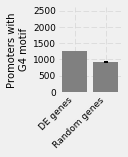

[1270, 922.75] 1.37632078028 (5, 0) MannwhitneyuResult(statistic=207.0, pvalue=0.04845096607462223)
(10, 0)


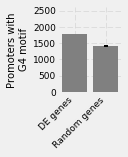

[1790, 1411.1400000000001] 1.26847796817 (10, 0) MannwhitneyuResult(statistic=225.0, pvalue=0.098740202058349213)
(15, 0)


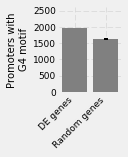

[1977, 1627.1800000000001] 1.21498543492 (15, 0) MannwhitneyuResult(statistic=228.0, pvalue=0.1099295970857293)
(15, 3)


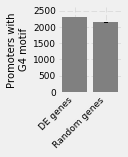

[2299, 2139.0100000000002] 1.07479628426 (15, 3) MannwhitneyuResult(statistic=262.0, pvalue=0.29950823396296333)
(50, 3)


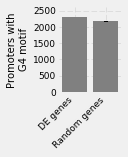

[2312, 2168.8600000000001] 1.0659978053 (50, 3) MannwhitneyuResult(statistic=262.5, pvalue=0.30309509554488639)


In [477]:
def calc_overlap(chrom):
    import pybedtools as pbt
    import numpy as np

    def load_g4_bed():
        g4_bed = []
        with open('/home/parashar/scratch/quadruplexes/hg19/g3_%s_%s_%s_nov.bed' %
                  (loop, bulge, chrom)) as h:
            for l in h:
                c = l.rstrip('\n').split('\t')
                s = '+' if c[4] == 'G' else '-'
                g4_bed.append('\t'.join(map(str, [c[0], c[1], c[2], '.', '0', s])))
        g4_bed = pbt.BedTool('\n'.join(g4_bed), from_string=True)
        return g4_bed

    def load_de_non_de_genes():
        de_bed = []
        rest_bed = []
        for gene, info in gene_info[chrom].items():
            if info[2] == '+':
                bed_line = '\t'.join(map(str, [chrom, info[0]-offset, info[0]+offset,
                                               gene, '0', info[2]]))
            else:
                bed_line = '\t'.join(map(str, [chrom, info[1]-offset, info[1]+offset,
                                               gene, '0', info[2]]))
            if gene in de_genes:
                de_bed.append(bed_line)
            else:
                rest_bed.append(bed_line)

        de_bed = pbt.BedTool('\n'.join(de_bed), from_string=True)
        rest_bed = pbt.BedTool('\n'.join(rest_bed), from_string=True)
        return de_bed, rest_bed

    g4_bed = load_g4_bed()
    de_bed, rest_bed = load_de_non_de_genes()
    g4_de = de_bed.intersect(g4_bed, u=True).count()
    
    rest_genes = []
    for i in rest_bed:
        rest_genes.append(str(i.name))
    rest_genes = np.array(list(set(rest_genes)))
    g4_rest = rest_bed.intersect(g4_bed, wo=True)
    g4_rest_genes = []
    for i in g4_rest:
        g4_rest_genes.append(str(i.name))
    g4_rest_genes = np.array(list(set(g4_rest_genes)))
    
    g4_rests = []
    for i in range(100):
        random_genes = set([rest_genes[np.random.randint(len(rest_genes))]
                        for x in range(len(de_bed))])
        g4_rests.append(len(random_genes.intersection(g4_rest_genes)))
    
    return g4_de, g4_rests

offset = 500
configs = [(5, 0), (10, 0), (15, 0), (15, 3), (50, 3)]

for config in configs:
    loop = str(config[0])
    bulge = str(config[1])

    _ = DVIEW.push(dict(
        de_genes=phendc3_up_genes+phendc3_down_genes,
        gene_info=chrom_wise_gene_locus_map,
        loop=loop,
        bulge=bulge,
        offset=offset
    ))
    
    print (config)
    
    res = DVIEW.map_sync(calc_overlap, chroms)
    g4_de, g4_rests = [], []
    for i in res:
        g4_de.append(i[0])
        g4_rests.append(i[1])
    g4_de = np.array(g4_de)
    g4_rests = np.array(g4_rests)
    
    fig, ax = plt.subplots(1, 1, figsize=(2, 2.4))
    x = [1,2]
    y = [g4_de.sum(), g4_rests.sum(axis=0).mean()]
    ax.bar(x, y, yerr=[0, g4_rests.sum(axis=0).std()], color='grey')
    ax.set_ylabel('Promoters with\nG4 motif', fontsize=10)
    ax.set_xticklabels(['', 'DE genes', 'Random genes'], fontsize=9, rotation=45, ha='right')
    ax.set_ylim((0, 2600))
    ax.set_yticks([x for x in range(0, 2600, 500)])
    clean_axis(ax)
    plt.tight_layout()
    plt.savefig('../images/phendc3_rna_seq_G4_%d_%d.png' % (config[0], config[1]), dpi=300,
                transparent=True, edgecolor='none')
    plt.savefig('../images/phendc3_rna_seq_G4_%d_%d.svg' % (config[0], config[1]),
                transparent=True, edgecolor='none')
    plt.show()
    print (y, y[0]/y[1], config, mannwhitneyu(g4_de, g4_rests.mean(axis=1)))

In [471]:
def load_scores(chrom, chrom_info, strand):
    fn = '../data/QG_expectation_scores_corrected_values/%s_%s.npy' % (chrom, strand)
    return np.load(fn, mmap_mode='r')

gene_names = []
exp_scores = []
offset = 500
for chrom in chroms:
    print (chrom)
    temp = []
    pos_exp = load_scores(chrom, chrom_info, 'positive')
    neg_exp = load_scores(chrom, chrom_info, 'negative')
    for gene, info in chrom_wise_gene_locus_map[chrom].items():
        gene_names.append(gene)
        if info[2] == '+':
            pos_score = pos_exp[info[0] - offset : info[0] + offset]
            neg_score = neg_exp[info[0] - offset : info[0] + offset]
        else:
            pos_score = pos_exp[info[1] - offset : info[1] + offset][::-1]
            neg_score = neg_exp[info[1] - offset : info[1] + offset][::-1]
        temp.append(np.array(pos_score) + np.array(neg_score))
    exp_scores.append(np.array(temp))
    clear_output()

In [472]:
de_exp = []
rest_exp = []
for n,chrom in enumerate(chroms):
    de_temp = []
    rest_temp = []
    for i,gene in enumerate(chrom_wise_gene_locus_map[chrom]):
        if gene in phendc3_up_genes or gene in phendc3_down_genes:
            de_temp.append(exp_scores[n][i])
        else:
            rest_temp.append(exp_scores[n][i])
    de_exp.append(np.array(de_temp))
    rest_exp.append(np.array(rest_temp))

(1000,) (1000,)
0.0135193805876 0.0104803887758 1.28996937774


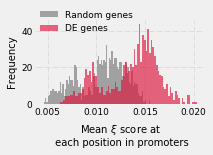

WilcoxonResult(statistic=17.0, pvalue=3.5000195640183923e-165)


In [495]:
a = []
chr_wise_count = []
for i in de_exp:
    a.extend(i)
a = np.array(a)

r = []
for i in rest_exp:
    r.extend(i)
r = np.array([r[np.random.randint(len(r))] for x in range(len(a))])

a = a.sum(axis=0)/len(a)
r = r.sum(axis=0)/len(r)

print (a.shape, r.shape)
print (a.mean(), r.mean(), a.mean()/r.mean())

fig, ax = plt.subplots(1, 1, figsize=(3.2, 2.2))

ax.hist(r, bins=80, alpha=0.7, color='grey', label='Random genes')
ax.hist(a, bins=80, alpha=0.65, color='crimson', label='DE genes')
ax.set_xlabel('Mean ' + r'$\xi$' + ' score at\n each position in promoters', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
ax.legend(frameon=False, loc= (0, 0.8), fontsize=9)
clean_axis(ax)
plt.tight_layout()
plt.savefig('../images/phendc3_rna_seq_exp_position_wise.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/phendc3_rna_seq_exp_position_wise.svg', transparent=True, edgecolor='none')

plt.show()

print (wilcoxon(a, r))

In [496]:
?wilcoxon

(2312,) (2312,)
0.213251094685 0.173285301263 1.23063579617 1.31283397783


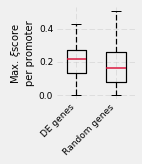

Ttest_indResult(statistic=11.445102419438269, pvalue=6.2736610855003463e-30)


In [491]:
a = []
chr_wise_count = []
for i in [x.max(axis=1) for x in de_exp]:
    a.extend(i)
    chr_wise_count.append(len(i))
a = np.array(a)

r = []
for i,c in zip([x.max(axis=1) for x in rest_exp], chr_wise_count):
    rand_idx = [np.random.randint(len(i)) for x in range(c)]
    r.extend(i[rand_idx])
r = np.array(r)

print (a.shape, r.shape)
print (a.mean(), r.mean(), a.mean()/r.mean(), np.median(a)/np.median(r))

fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.5))

boxprops = dict(linestyle='-', linewidth=1.2, color='k')
whiskerprops = dict(linestyle='--', linewidth=1.2, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([a, r], sym='', widths=0.5, boxprops=boxprops, 
           medianprops=medianprops, whiskerprops=whiskerprops)
ax.set_ylabel('Max. ' + r'$\xi$' + 'score\nper promoter', fontsize=10)
ax.set_xticklabels([
        'DE genes', 'Random genes',
    ], rotation=45, fontsize=10, ha='right')
clean_axis(ax)

plt.tight_layout()
plt.savefig('../images/phendc3_rna_seq_exp.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/phendc3_rna_seq_exp.svg', transparent=True, edgecolor='none')

plt.show()

print (ttest_ind(a, r))

In [509]:
exp_cutoff = 0.01

de_exp_cut = []
chr_wise_count = []
for i in de_exp:
    temp = 0
    for j in i:
        temp += len(np.where(j > exp_cutoff)[0])
    de_exp_cut.append(temp)
    chr_wise_count.append(len(i))
de_exp_cut = np.array(de_exp_cut)

rest_exp_cut = []

for i,c in zip(rest_exp, chr_wise_count):
    temp = []
    for n in range(100):
        t = 0
        random_rest_exp = np.array([i[np.random.randint(len(i))]
                                    for x in range(c)])
        for j in random_rest_exp:
            t += len(np.where(j > exp_cutoff)[0])
        temp.append(t)
    rest_exp_cut.append(np.array(temp))
rest_exp_cut = np.array(rest_exp_cut)
de_exp_cut, rest_exp_cut.shape, np.mean(rest_exp_cut), np.std(rest_exp_cut)

(array([43671, 26919, 21069, 13071, 19776, 14568, 22715, 13834, 16074,
        18920, 27844, 19820,  6765, 13334, 11666, 26406, 29889,  5364,
        40966,  9256,  4090, 13626,  9783,   249]),
 (24, 100),
 14446.767916666666,
 8645.5801914362)

[429.67500000000001, 346.72242999999997] 1.23924777523 Ttest_indResult(statistic=6.5917808506332047, pvalue=3.7392012937457889e-08)


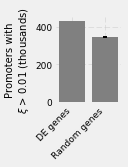

In [516]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2.4))
x = [1,2]
temp = rest_exp_cut.sum(axis=0)
y = [sum(de_exp_cut)/1000, temp.mean()/1000]
yerr = [0, temp.std()/1000]

ax.bar(x, y, yerr=yerr, color='grey')
ax.set_ylabel('Promoters with\n' + r'$\xi$' + ' > 0.01 (thousands)', fontsize=10)
ax.set_xticklabels(['', 'DE genes', 'Random genes'], fontsize=9, rotation=45, ha='right')
#ax.set_ylim((0, 2600))
#ax.set_yticks([x for x in range(0, 2600, 500)])
clean_axis(ax)
plt.tight_layout()
plt.savefig('../images/phendc3_rna_seq_e_0.01.png', dpi=300,
            transparent=True, edgecolor='none')
plt.savefig('../images/phendc3_rna_seq_e_0.01.svg',
            transparent=True, edgecolor='none')
print (y, y[0]/y[1], ttest_ind(de_exp_cut/chr_wise_count,
                                  rest_exp_cut.mean(axis=1)/chr_wise_count))

plt.show()

In [517]:
sum(de_exp_cut)

429675